# Bùi Hoàng Phúc </br>
# MSSV: 18055891

In [ ]:
# !pip install fasttext
!pip install unidecode
!pip install rouge_score
!pip install "nltk==3.6.1"

     |████████████████████████████████| 235 kB 7.6 MB/s 
     |████████████████████████████████| 1.5 MB 7.5 MB/s 
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


### Import thư viện

In [ ]:
# import fasttext
import pickle
import numpy as np
import time
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed,Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import time
import pickle
warnings.filterwarnings("ignore")

In [ ]:
%cd /content/drive/MyDrive/DichMay/data

/content/drive/.shortcut-targets-by-id/1t5rcQSl1xJ3ZdrET_uynZzQ1BdnfyJbm/DichMay/data


## Preprocessing

In [ ]:
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    tokens=newString.split()
    return (" ".join(tokens)).strip()
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}
                        

def standardize_data(row):
    row = row.lower()
    row = re.sub(r"[\,\?]+$-", "", row)
    row = re.sub("(\s)+", r"\1", row)
    # Xóa tất cả dấu chấm, phẩy, chấm phẩy, chấm thang, ... trong câu
    row = row.replace(",", " ").replace(".", " ") \
        .replace(";", " ").replace("“", " ") \
        .replace(":", " ").replace("”", " ") \
        .replace('"', " ").replace("'", " ") \
        .replace("!", " ").replace("=", " ") \
        .replace("(", " ").replace(")", " ") \
        .replace("-", " ").replace("?", " ")
    row = ''.join(i for i in row if not i.isdigit())
    tokens=row.split()
    return (" ".join(tokens)).strip()


In [ ]:
!pip install underthesea
from underthesea import word_tokenize
def tokenizer(row):
    return word_tokenize(row, format="text")

## Load data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/DichMay/data_final/data.csv')

In [ ]:
class Language:
  def __init__(self, data):
    self.w2i = {'<s>':1, '</s>':2, '<pad>':0}
    self.i2w = {1:'<s>', 2:'</s>', 0:'<pad>'}
    self.maxlen = 0
    self.vocab_size = 3
    self.create(data)
  def create(self, data):
    for i in data:
      s = i.split()
      if len(s)>self.maxlen:
        self.maxlen = len(s)
      for j in s:
        if j not in self.w2i.keys():
          self.w2i[j] = self.vocab_size
          self.i2w[self.vocab_size] = j
          self.vocab_size+=1
  def encode(self, text):
    return [1]+[self.w2i[i] for i in text.split()]+[2]
  
  def decode(self, ids):
    start = 0 if ids[0]!=1 else 1
    end = ids.index(2) if 2 in ids else None
    return ' '.join(self.i2w[i] for i in ids[start:end])

In [ ]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [ ]:
data

,Unnamed: 0,en,vi
0,0,i want to tell you about the magnitude of the ...,tôi muốn cho các bạn biết về sự to_lớn của nhữ...
1,1,there are lines that look like this when it co...,có những dòng trông như thế_này khi bàn về biế...
2,2,both are branches of the same field in atmosph...,cả hai đều là một nhánh của cùng một lĩnh_vực ...
3,3,the headlines recently looked like this when t...,các tiêu_đề gần đây trông như thế_này khi ban ...
4,4,the study was written by scientists from dif...,nghiên_cứu được viết bởi nhà_khoa_học từ quố...
...,...,...,...
169502,169570,b in case learners receive a degree from both ...,trường_hợp cấp văn_bằng của cả cơ_sở giáo_dục ...
169503,169571,article training program size,điều quy_mô đào_tạo
169504,169572,the number of admission slots of a joint train...,quy_mô đào_tạo của chương_trình liên_kết được ...
169505,169573,the vietnamese institution and the foreign ins...,cơ_sở đào_tạo việt nam và cơ_sở giáo_dục đại_h...


In [ ]:
vocab_ipt = Language(data['en'])
vocab_opt = Language(data['vi'])
vocab_ipt.vocab_size, vocab_opt.vocab_size

(36525, 36242)

In [ ]:
ipt_train = []
opt_train = []

for i in data['en']:
  ipt_train.append(vocab_ipt.encode(i))
for i in data['vi']:
  opt_train.append(vocab_opt.encode(i))

In [ ]:
len(ipt_train),len(opt_train)

(169497, 169497)

In [ ]:
encoder_maxlen = 100
decoder_maxlen = 100
encoder_maxlen,decoder_maxlen

(100, 100)

In [ ]:
ipt_train = pad_sequences(ipt_train, maxlen=encoder_maxlen, padding='post')
opt_train = pad_sequences(opt_train, maxlen=decoder_maxlen, padding='post')

In [ ]:
with open('data_train.pkl', 'wb') as f:
  pickle.dump([ipt_train, opt_train], f)
# with open('/content/drive/MyDrive/DichMay/data_final/data_train.pkl', 'rb') as f:
#   ipt_train, opt_train = pickle.load(f)

In [ ]:
ipt_train.shape, opt_train.shape

((169497, 100), (169497, 100))

In [ ]:
ipt_train, test_x, opt_train, test_y = train_test_split(ipt_train, opt_train, test_size = 0.05)

In [ ]:
BUFFER_SIZE = len(ipt_train)
BATCH_SIZE = 32
steps_per_epoch = len(ipt_train)//BATCH_SIZE
dataset = tf.data.Dataset.from_tensor_slices((ipt_train, opt_train)).shuffle(BUFFER_SIZE)
dataset = dataset.cache()
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
encoder_vocab_size = vocab_ipt.vocab_size
decoder_vocab_size = vocab_opt.vocab_size
encoder_vocab_size,decoder_vocab_size

(36525, 36242)

## model Transformer

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.2

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model) # shape (position, d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32) # shape: (position, d_model)

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32) # depth
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):
    # print('enc_padding_mask: ', enc_padding_mask)
    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [ ]:
transformer = Transformer(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
                          input_vocab_size=encoder_vocab_size, target_vocab_size=decoder_vocab_size, 
                          pe_input=encoder_vocab_size, 
                          pe_target=decoder_vocab_size,
                          rate=dropout_rate)

In [ ]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  dec_padding_mask = create_padding_mask(inp)

  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
checkpoint_path = "/content/drive/MyDrive/DichMay/checkpoints3"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
def predict(sent):
  encoder_input = pad_sequences([sent], maxlen=encoder_maxlen, padding='post')
  output = tf.convert_to_tensor([1], dtype=tf.int64)
  output = tf.expand_dims(output, 0)
  for i in range(100):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
    predictions, _ = transformer(encoder_input,
                                output,
                                False,
                                enc_padding_mask,
                                combined_mask,
                                dec_padding_mask)
    predictions = predictions[:, -1:, :]
    predicted_id = tf.argmax(predictions, axis=-1)
    output = tf.concat([output, predicted_id], axis=-1)
    if predicted_id == 2:
      break
  return output

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import random
import nltk
nltk.download('wordnet')
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)


def score(sample):
  """
  hàm tính điểm  cho mô hình
  """
  references = []
  candidate = []
  all_score= []
  scores1 = []
  scoresL = []
  score_bleu = []
  n = sample
  d_score = {'Rouge1': [],'RougeL':[]}
  for _ in range(sample):

    i  =  random.randrange(0, len(test_x))
    try:
      pred = predict(test_x[i])
    except:
      sample+=1
      continue
    pred = vocab_opt.decode([j for j in pred.numpy()[0]])
    label= vocab_opt.decode([j for j in test_y[i]])

    
    #Rouge score
    score = scorer.score(pred,label)
    scores1.append(score['rouge1'][0])
    scoresL.append(score['rougeL'][0])

    #Meteor score
    all_score.append(meteor_score([label],pred))

    candidate = pred.split()
    references = [label.split()]
    score_bleu.append(sentence_bleu(references, candidate,weights=(0.25, 0.25)))
    #Bleu score
    
  scores1 = np.mean(scores1)
  scoresL = np.mean(scoresL)
  score_bleu = np.mean(score_bleu)
  
  score_meteor = sum(all_score)/n
  
  return score_bleu,score_meteor,scores1,scoresL

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
@tf.function
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [ ]:
epochs = 10
losses = []
acc = []
for epoch in range(epochs):
  start = time.time()
  train_loss.reset_states()
  train_accuracy.reset_states()
  for (batch, (inp, tar)) in enumerate(dataset.take(steps_per_epoch)):
    train_step(inp, tar)
    if batch % 3000 == 0:
      losses.append(train_loss.result().numpy())
      bleu, meteor, rouge1, rouge2 = score(20)
      acc.append([bleu, meteor, rouge1, rouge2])
      with open('/content/drive/MyDrive/DichMay/data/score1.pkl', 'wb') as f:
        pickle.dump([acc, losses], f)
      print ('Epoch {} Batch {} Loss {:.4f} Bleu {:.3f} Meteor {:.3f} Rouge1 {:.3f} Rouge2 {:.3f}'.format(
          epoch + 1, batch, train_loss.result(), bleu, meteor, rouge1, rouge2))
      
  if (epoch + 1) % 2 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 10.3841 Bleu 0.000 Meteor 0.000 Rouge1 0.054 Rouge2 0.049
Epoch 1 Batch 3000 Loss 5.9996 Bleu 0.038 Meteor 0.078 Rouge1 0.388 Rouge2 0.295
Time taken for 1 epoch: 5633.724128246307 secs

Epoch 2 Batch 0 Loss 5.2485 Bleu 0.123 Meteor 0.126 Rouge1 0.442 Rouge2 0.331
Epoch 2 Batch 3000 Loss 5.1894 Bleu 0.118 Meteor 0.125 Rouge1 0.440 Rouge2 0.318
Saving checkpoint for epoch 2 at /content/drive/MyDrive/DichMay/checkpoints3/ckpt-1
Time taken for 1 epoch: 5662.912712335587 secs

Epoch 3 Batch 0 Loss 4.9614 Bleu 0.203 Meteor 0.169 Rouge1 0.497 Rouge2 0.374
Epoch 3 Batch 3000 Loss 4.8024 Bleu 0.164 Meteor 0.154 Rouge1 0.449 Rouge2 0.321
Time taken for 1 epoch: 5607.301152467728 secs

Epoch 4 Batch 0 Loss 4.2700 Bleu 0.196 Meteor 0.161 Rouge1 0.526 Rouge2 0.379
Epoch 4 Batch 3000 Loss 4.3306 Bleu 0.404 Meteor 0.334 Rouge1 0.580 Rouge2 0.487
Saving checkpoint for epoch 4 at /content/drive/MyDrive/DichMay/checkpoints3/ckpt-2
Time taken for 1 epoch: 5587.971400022507 secs

Epo

### Đánh giá mô hình Transformer

In [ ]:
with open('/content/drive/MyDrive/DichMay/data/score1.pkl', 'rb') as f:
      acc, losses =   pickle.load(f)

In [ ]:
bleu = []
metor =[]
rouge1=[]
rougeL=[]
for i in range(0,20,2):
  bleu.append(np.mean(np.array(acc)[i:i+2, 0]))
  metor.append(np.mean(np.array(acc)[i:i+2, 1]))
  rouge1.append(np.mean(np.array(acc)[i:i+2, 2]))
  rougeL.append(np.mean(np.array(acc)[i:i+2, 3]))

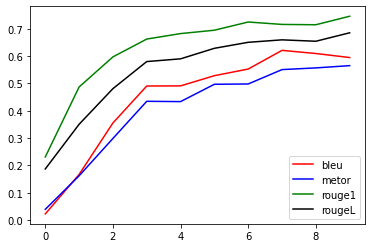

In [ ]:
import matplotlib.pyplot as plt

plt.plot(bleu, color='r')
plt.plot(metor, color = 'b')
plt.plot(rouge1, color = 'g')
plt.plot(rougeL, color = 'black')
plt.legend(['bleu', 'metor', 'rouge1', 'rougeL'])
plt.show()

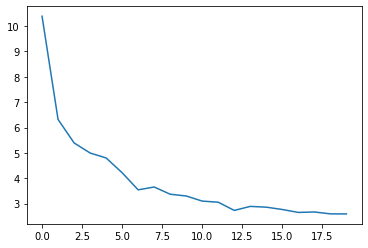

In [ ]:
plt.plot(losses)
plt.show()

### Test với dữ liệu ngoài

In [ ]:
def predict(text):
      encode = [vocab_ipt.encode(text)]
      encoder_input = pad_sequences(encode, maxlen=encoder_maxlen, padding='post')
      
      output = tf.convert_to_tensor([1], dtype=tf.int64)
      output = tf.expand_dims(output, 0)
      for i in range(1000):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)
        predictions, _ = transformer(encoder_input,
                                    output,
                                    False,
                                    enc_padding_mask,
                                    combined_mask,
                                    dec_padding_mask)
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int64)
        output = tf.concat([output, predicted_id], axis=-1)
        if predicted_id == 2:
            return vocab_opt.decode([i for i in output.numpy()[0]]).replace('_',' ')
      return vocab_opt.decode([i for i in output.numpy()[0]]).replace('_',' ')
    

In [ ]:
def text_cleaner(text):
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z|^,|^0-9|^'s]", " ", newString) 
    newString = newString.replace(', ',' , ')
    newString = re.sub('[m]{2,}', 'mm', newString)
    tokens=newString.split()
    return (" ".join(tokens)).strip()

In [ ]:
def evaluate(text):
    text = text_cleaner(text)
    results = ''
    index = 0
    for x in text.split():
        
        if x not in vocab_ipt.w2i.keys() and x!=',':
          child = []
          for y in text[index:text.index(x,index)].split(' , '):
            child.append(predict(y))
          results+=', '.join(child)+' ' + x + ' '

          index =text.index(x,index) + len(x) 
        elif x in vocab_ipt.w2i.keys() and x==text.split()[-1]:
          
          child = []
          for y in text[index:].split(' , '):
            child.append(predict(y))
          results+=', '.join(child)
    return re.sub('\s+', ' ', results)


In [ ]:
evaluate('Both of my physical and  mental health become better after I play sports, so it can be considered as the best things to do in my free time.')

'cả hai người trong vật lý và y tế tinh thần của tôi trở nên tốt hơn sau khi tôi chơi thể thao, vì vậy nó có thể được xem như những thứ tốt nhất để làm trong thời gian miễn phí của tôi'

In [ ]:
evaluate('hello my name is phuc, do you need me help something zzzz')

'xin chào tên tôi là phuc , bạn có cần tôi giúp đỡ một thứ gì đó là sự thời trang không'

In [ ]:
evaluate('''This package is a great option if you’re looking for a complete annual physical exam \
        that can get a clearer picture of your health because it is specifically designed for the \ 
        needs of young adults, adult men, or adult women.''')

'gói này là một lựa chọn tuyệt vời nếu bạn nhìn lại một cuộc thi toán học hoàn toàn có thể nhận được một bức tranh rõ ràng hơn về sức khoẻ của bạn bởi vì nó là một nhu cầu thiết kế cho những người trưởng thành, đàn ông người lớn, hay người lớn'

In [ ]:
evaluate('Till their higher school students used to study in various fields')

'sự giám sát của họ càng cao học sinh của họ đã từng nghiên cứu trong các lĩnh vực khác nhau'

## model Sequence to Sequence with Attention

In [ ]:
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
ENC_HID_DIM = 256
DEC_HID_DIM = 256

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
  
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state
  # khởi tạo first state để  trả về last state
  
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units)) 

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)

    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    # trả về last state của decode cho lần train từ kế tiếp 
    return x, state, attention_weights

In [ ]:
encoder = Encoder(encoder_vocab_size, ENC_EMB_DIM, ENC_HID_DIM, BATCH_SIZE)
decoder = Decoder(decoder_vocab_size, DEC_EMB_DIM, DEC_HID_DIM, BATCH_SIZE)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [ ]:
def predict(input_document):
    
    # input_document = tokenizer_en.texts_to_sequences([input_document])
    input_document = pad_sequences([input_document], maxlen=encoder_maxlen, padding='post', truncating='post')
    input_document = tf.convert_to_tensor(input_document)

    result = []

    hidden = [tf.zeros((1, ENC_HID_DIM))]
    enc_out, enc_hidden = encoder(input_document, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([1], 0)


    
    for i in range(decoder_maxlen):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                          dec_hidden,
                                                          enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(predicted_id)
        if predicted_id == 2:
            return vocab_opt.decode([i for i in result])

        dec_input = tf.expand_dims([predicted_id], 0)
    return  vocab_opt.decode([i for i in result])

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import random
import nltk
nltk.download('wordnet')
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)


def score(sample):
  """
  hàm tính điểm  cho mô hình
  """
  references = []
  candidate = []
  all_score= []
  scores1 = []
  scoresL = []
  score_bleu = []
  n = sample
  d_score = {'Rouge1': [],'RougeL':[]}
  for _ in range(sample):

    i  =  random.randrange(0, len(test_x))
    try:
      pred = predict(test_x[i])
    except:
      sample+=1
      continue
    label= vocab_opt.decode([j for j in test_y[i]])
    
    #Rouge score
    score = scorer.score(pred,label)
    scores1.append(score['rouge1'][0])
    scoresL.append(score['rougeL'][0])

    #Meteor score
    all_score.append(meteor_score([label],pred))

    candidate = pred.split()
    references = [label.split()]
    score_bleu.append(sentence_bleu(references, candidate,weights=(0.25, 0.25)))
    #Bleu score
    
  scores1 = np.mean(scores1)
  scoresL = np.mean(scoresL)
  score_bleu = np.mean(score_bleu)
  
  score_meteor = sum(all_score)/n
  
  return score_bleu,score_meteor,scores1,scoresL

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    # bắt đầu từ ký tự start
    dec_input = tf.expand_dims([1] * BATCH_SIZE, 1)
    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      # decode hidden == state decode
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # duyệt qua từ kế tiếp
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
import os
checkpoint_dir = '/content/drive/MyDrive/DichMay/checkpoint_s2s2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,encoder=encoder,decoder=decoder)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
EPOCHS = 10
losses = []
acc = []

for epoch in range(EPOCHS):
  start = time.time()
  
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 3000 == 0:
      losses.append(batch_loss.numpy())
      bleu, meteor, rouge1, rouge2 = score(20)
      acc.append([bleu, meteor, rouge1, rouge2])
      with open('/content/drive/MyDrive/DichMay/data/score_s2s2.pkl', 'ab') as f:
        pickle.dump([acc, losses], f)
      print ('Epoch {} Batch {} Loss {:.4f} Bleu {:.3f} Meteor {:.3f} Rouge1 {:.3f} Rouge2 {:.3f}'.format(
          epoch + 1, batch, batch_loss.numpy(), bleu, meteor, rouge1, rouge2))
  # saving (checkpoint) the model every 2 epochs
  if (epoch+1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.0914 Bleu 0.000 Meteor 0.001 Rouge1 0.002 Rouge2 0.002
Epoch 1 Batch 3000 Loss 1.6157 Bleu 0.450 Meteor 0.211 Rouge1 0.459 Rouge2 0.364
Epoch 1 Loss 2.0568
Time taken for 1 epoch 383.64846444129944 sec

Epoch 2 Batch 0 Loss 1.5785 Bleu 0.454 Meteor 0.293 Rouge1 0.487 Rouge2 0.396
Epoch 2 Batch 3000 Loss 1.5244 Bleu 0.495 Meteor 0.295 Rouge1 0.576 Rouge2 0.480
Epoch 2 Loss 1.4919
Time taken for 1 epoch 340.3239595890045 sec

Epoch 3 Batch 0 Loss 1.4653 Bleu 0.539 Meteor 0.351 Rouge1 0.589 Rouge2 0.496
Epoch 3 Batch 3000 Loss 1.1489 Bleu 0.522 Meteor 0.378 Rouge1 0.605 Rouge2 0.518
Epoch 3 Loss 1.2367
Time taken for 1 epoch 338.4552710056305 sec

Epoch 4 Batch 0 Loss 0.9159 Bleu 0.585 Meteor 0.424 Rouge1 0.630 Rouge2 0.527
Epoch 4 Batch 3000 Loss 0.9405 Bleu 0.590 Meteor 0.417 Rouge1 0.653 Rouge2 0.575
Epoch 4 Loss 1.0381
Time taken for 1 epoch 339.71518301963806 sec

Epoch 5 Batch 0 Loss 0.8890 Bleu 0.601 Meteor 0.444 Rouge1 0.672 Rouge2 0.612
Epoch 5 Batch 3000 L

### Đánh giá mô hình S2S

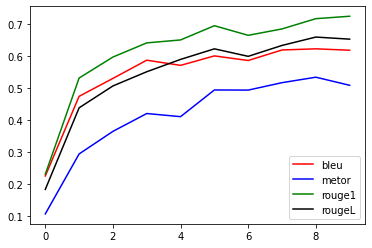

In [ ]:
import matplotlib.pyplot as plt
bleu = []
metor =[]
rouge1=[]
rougeL=[]
for i in range(0,20,2):
  bleu.append(np.mean(np.array(acc)[i:i+2, 0]))
  metor.append(np.mean(np.array(acc)[i:i+2, 1]))
  rouge1.append(np.mean(np.array(acc)[i:i+2, 2]))
  rougeL.append(np.mean(np.array(acc)[i:i+2, 3]))
plt.plot(bleu, color='r')
plt.plot(metor, color = 'b')
plt.plot(rouge1, color = 'g')
plt.plot(rougeL, color = 'black')
plt.legend(['bleu', 'metor', 'rouge1', 'rougeL'])
plt.show()

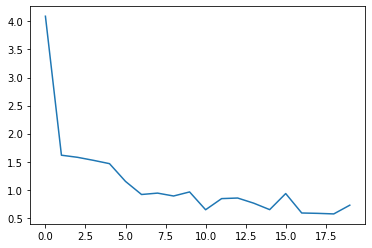

In [ ]:
plt.plot(losses)
plt.show()

### Test với dữ liệu ngoài

In [ ]:
def standardize_data(row):
    row = row.lower()
    row = re.sub(r"[\,\?]+$-", "", row)
    row = re.sub("(\s)+", r"\1", row)
    # Xóa tất cả dấu chấm, phẩy, chấm phẩy, chấm thang, ... trong câu
    row = row.replace(",", " ").replace(".", " ") \
        .replace(";", " ").replace("“", " ") \
        .replace(":", " ").replace("”", " ") \
        .replace('"', " ").replace("'", " ") \
        .replace("!", " ").replace("=", " ") \
        .replace("(", " ").replace(")", " ") \
        .replace("-", " ").replace("?", " ")
    row = ''.join(i for i in row if not i.isdigit())
    tokens=row.split()
    return (" ".join(tokens)).strip()

In [ ]:
def evaluate(input_document):
    input_document = standardize_data(input_document)
    input_document = [vocab_ipt.encode(input_document)]
    input_document = pad_sequences(input_document, maxlen=encoder_maxlen, padding='post', truncating='post')
    input_document = tf.convert_to_tensor(input_document)

    result = []

    hidden = [tf.zeros((1, ENC_HID_DIM))]
    enc_out, enc_hidden = encoder(input_document, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([1], 0)


    
    for i in range(decoder_maxlen):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                          dec_hidden,
                                                          enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(predicted_id)
        if predicted_id == 2:
            return vocab_opt.decode([i for i in result]).replace('_',' ')

        dec_input = tf.expand_dims([predicted_id], 0)
    return  vocab_opt.decode([i for i in result]).replace('_',' ')

In [ ]:
evaluate('''Both of my physical and mental health become better after I play sports , so it can be considered as the best things to do in my free time. .''')

'cả hai và thể_chất tinh_thần và tinh_thần của bạn trở_thành tốt hơn khi tôi chơi thể_thao nên nó có_thể được coi như những điều tốt nhất để làm trong những lời khuyên để làm trong những lời khuyên để làm'